# CHIN303 Final Project: 
# Exploring Major Events and Event Connections between 2019 – 2020
# Using Topic Modeling via NMF

In [1]:
import os.path
import jieba
import joblib
import operator
import gensim
import re
import numpy as np
import pandas as pd
from itertools import combinations
from sklearn import decomposition
from sklearn.externals import joblib
from sklearn.feature_extraction.text import TfidfVectorizer

%matplotlib inline
import matplotlib
# mpl.use("Cairo")

import matplotlib.pyplot as plt
import seaborn as sns

# Module to visualize topic model
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Functions Needed

In [2]:
# this function helps to take out all spaces
def process(our_data):
    m1 = map(lambda s: s.replace(' ', ''), our_data)
    return list(m1)

In [3]:
# these functions combine to help keep only Chinese characters
def is_chinese(uchar):
    if uchar >= u'\u4e00' and uchar <= u'\u9fa5':
        return True
    else:
        return False

def format_str(content):
    content_str = ''
    for i in content:
        if is_chinese(i):
            content_str = content_str + ｉ
    return content_str

In [4]:
# this function helps to tokenize Chinese articles in a way that will fit into tfidf vectorizer
def fenci(datas):
    cut_words = map(lambda s: list(jieba.cut(s)), datas)
    return [" ".join(words) for words in cut_words]

# this function helps to tokenize Chinese articles in a way that will fit into word2vec
def fanci(datas):
    seg_list=[]
    for data in datas:
        cut_words = jieba.lcut(data)
        seg_list.append(cut_words)
    return seg_list

In [5]:
# this function helps to display terms with the highest TF-IDF scores across all documents in the document-term matrix
def rank_terms (A, terms):
    # get the sums over each column
    sums = A.sum(axis=0)
    # map weights to the terms
    weights = {}
    for col, term in enumerate(terms):
        weights[term] = sums[0,col]
    # rank the terms by their weight over all documents
    return sorted(weights.items(), key=operator.itemgetter(1), reverse=True)

In [6]:
# this function helps to calculate degree of coherence for different word2vec models with differnent k values
def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            pair_scores.append( w2v_model.wv.similarity(pair[0], pair[1]) )
        # print(pair_scores)
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

In [7]:
# this function helps to get descriptor for the topics with list of top terms
def get_descriptor( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( all_terms[term_index] )
    return top_terms

In [8]:
# this function helps to create a bar chart for the specified topic, based on the H factor from the current NMF model
def plot_top_term_weights( terms, H, topic_index, top ):
    # get the top terms and their weights
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    top_terms = []
    top_weights = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
        top_weights.append( H[topic_index,term_index] )
    # note we reverse the ordering for the plot
    top_terms.reverse()
    top_weights.reverse()
    # create the plot
    fig = plt.figure(figsize=(13,8))
    # add the horizontal bar chart
    ypos = np.arange(top)
    ax = plt.barh(ypos, top_weights, align="center", color="green",tick_label=top_terms)
    plt.xlabel("Term Weight",fontsize=14)
    plt.tight_layout()
    plt.show()
    plt.savefig("word.png",dpi=1200)

In [9]:
# this functions helps to produce the ranking of the top-ranked documents for a given topic with their snippets shown
def get_top_snippets( all_snippets, W, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( W[:,topic_index] )[::-1]
    # now get the snippets corresponding to the top-ranked indices
    top_snippets = []
    for doc_index in top_indices[0:top]:
        top_snippets.append( all_snippets[doc_index] )
    return top_snippets

## Text Preprocessing

In [10]:
# loading the document: 
# a corpus of Chinese-language news articles downloaded from Nei.st has been stored in a single file
# and formatted so that one article appears on each line
raw_documents = []
snippets = []
# with open(os.path.join("data","nei_articles.txt"),'r') as rf:
with open("nei_articles.txt",'r') as rf:
#     text = rf.read()
#     text = re.sub(r'\n{2,}', '\n', text)
#     docs = re.split(r"\n", text)
#     print(len(docs))
#     for line in docs:
#         raw_documents.append(line)
    for line in rf.readlines():
        text = line.strip()
        # load these articles into a list
        raw_documents.append(text)
        # also create a short snippet of text up to 100 characters as a title for each article
        snippets.append(text[0:min(len(text),150)])
print(f"Read {len(raw_documents)} raw text documents")

Read 1519 raw text documents


In [11]:
# testing
# print(raw_documents[1518])
# delete spaces in the articles
space_free = process(raw_documents)

# keep only Chinese characters in the articles
chinese_list = []
for line in space_free:
    chinese_list.append(format_str(line))

# testing
# print(chinese_list[:2])
# print(chinese_list[0] is "")

In [12]:
# I want to know which news articles are purly English articles and track them
number = []
for count, string in enumerate(chinese_list):
    if string is "":
        number.append(count)
print(number)
    
# those purely English articles will appear as empty strings in the articles list. filter them out
chinese_list = [string for string in chinese_list if string != ""]

[8, 75, 122]


In [13]:
# word segmentation, tokenization
seg_list_tfidf = fenci(chinese_list) # seg_list_tfidf will be used to produce TfidfVectorizer
seg_list_word2vec = fanci(chinese_list) # seg_list_word2vec will be used to produce word2vec
# print(seg_list_word2vec[:2])

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/c6/3bq133694494kqlskrqkxxlw0000gn/T/jieba.cache
Loading model cost 3.748 seconds.
Prefix dict has been built successfully.


In [14]:
seg_list_tfidf[0:2]

['时隔 半个世纪 我们 依然 能 感受 到 这份 文献 中 足够 震撼 的 前瞻性 力量 增长 的 极限 里 的 预言 已经 压倒性 地 堆积 到 了 我们 岌岌可危 的 全球化 面前 少时 读 福尔摩斯 不可 免俗 地被 一个 神奇 组织 吸引 在 故事 希腊 议员 里 夏洛克 隆重推出 了 自己 的 哥哥 迈 克罗夫特 称 他 来自 伦敦 最 古怪 的 俱乐部 第欧根尼 俱乐部 很 可能 你 不 知道 伦敦 有 许多 人有 的 生性 羞怯 有 的 愤世嫉俗 他们 不愿 与 人 为伍 为了 这个 目的 第欧根尼 俱乐部 便 诞生 了 现在 它 接纳 城里 最 孤僻 和 最 不爱交际 的 人 我 哥哥 是 俱乐部 发起人 之一 到 了 英剧 神探 夏洛克 编剧 索性 让 哥哥 成 了 一个 隐形 大人物 手握 重权 俨然 一位 政府 要员 只是 迟迟 不 点破 他 的 实际 头衔 总结 起来 这种 俱乐部 一般 具有 如下 特点 成员 一律 高智商 人士 都 很 低调 实际上 非富 即 贵在 紧要关头 能够 呼风唤雨 改变 全局 走向 无论如何 它 的 出现 让 我 这样 的 故事 爱好者 心怀 向往 等到 后来 年岁 渐长 知道 了 一些 奇怪 的 知识 才 发现 现实 世界 中 也 不乏 这样 的 组织 比如 起源于 耶鲁大学 兄弟会 的 组织 骷髅 会 成员 多 是 美国 政 商界 的 大人物 包括 三位 美国 总统 以及 多位 联邦 大法官 和 大学校长 此外 共济会 光明 派 罗马 俱乐部 比尔 德堡 团 哥伦布 骑士团 等 组织 也 在历史上 赫赫有名 今天 想要 重点 介绍 的 是 罗马 俱乐部 因为 它 是 上述 神秘 组织 中 科学家 比例 最高 的 一个 它 出现 的 年份 也 很 特别 年 那 一年 在 法国巴黎 发生 的 五月 风暴 很快 成为 席卷 欧美 年轻人 的 世界 运动 罗马 俱乐部 则 早 一个月 前 在 意大利 成立 当年 月 一群 来自 学术界 民间团体 外交 和 工业 领域 的 各国 精英 在 罗马 特拉斯 提弗列 的 法尔 内 西纳 别墅 举行 会面 决定 成立 该 俱乐部 不管 是 五月 风暴 还是 这次 罗马 聚会 以及 同一 时期 发生 的 许多 其他 事件 背后 都 有 一个 深层 原因 消费主义 热 在 西方 

In [15]:
# apply the stopwords list
custom_stop_words = []
with open(os.path.join("stopwords","baidu_stopwords.txt"),"r") as rf:
    for line in rf.readlines():
        custom_stop_words.append(line.strip())
# note that we need to make it hashable
print(f"Stopword list has {len(custom_stop_words)} entries")

Stopword list has 1480 entries


In [16]:
# generate a TF-IDF weighted document-term matrix by using TfidfVectorizer
# we can pass in the preprocessing parameters

# vectorizer = TfidfVectorizer(stop_words=custom_stop_words, min_df=20)
# A = vectorizer.fit_transform(seg_list_tfidf)
vectorizer = TfidfVectorizer(
    #ngram_range=(1,2), 
    stop_words=custom_stop_words, min_df=0.01, max_df=0.5, use_idf=True, sublinear_tf=True)
A = vectorizer.fit_transform(seg_list_tfidf)
print("Created %d * %d TF-IDF-normalized document-term matrix" % (A.shape[0], A.shape[1]))

# extract the resulting vocabulary
terms = vectorizer.get_feature_names()
print(f"Vocabulary has {len(terms)} distinct terms")

# now display a ranking of the top 20 terms
ranking = rank_terms(A, terms)
for i, pair in enumerate(ranking[:100]):
    print("%02d. %s (%.2f)" % (i+1, pair[0], pair[1]))

# save this document-term matrix, terms, and snippets for topic modelling later using Joblib
joblib.dump((A, terms, snippets, vectorizer), "articles-tfidf.pkl")

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ain', 'aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'll', 'mon', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Created 1516 * 9598 TF-IDF-normalized document-term matrix
Vocabulary has 9598 distinct terms
01. 疫情 (26.90)
02. 数据 (24.05)
03. 亿美元 (23.19)
04. 投资 (22.67)
05. 增长 (21.74)
06. 世界 (21.64)
07. 记者 (21.26)
08. 政策 (21.18)
09. 计划 (21.05)
10. 技术 (20.81)
11. 香港 (20.80)
12. 北京 (20.58)
13. 机构 (20.45)
14. 政治 (20.12)
15. 病毒 (20.09)
16. 社会 (20.09)
17. 产品 (19.45)
18. 行业 (19.42)
19. 人士 (19.34)
20. 官员 (19.26)
21. 支持 (19.09)
22. 导致 (18.94)
23. 服务 (18.70)
24. 方式 (18.65)
25. 未来 (18.51)
26. 信息 (18.45)
27. 地区 (18.29)
28. 城市 (18.29)
29. 项目 (18.25)
30. 武汉 (18.24)
31. 生产 (18.04)
32. 增加 (17.94)
33. 风险 (17.91)
34. 媒体 (17.88)
35. 国际 (17.79)
36. 活动 (17.79)
37. 特朗普 (17.65)
38. 原因 (17.59)
39. 控制 (17.27)
40. 管理 (17.24)
41. 措施 (17.24)
42. 业务 (17.08)
43. 人员 (17.04)
44. 成本 (16.90)
45. 集团 (16.82)
46. 新冠 (16.81)
47. 感染 (16.68)
48. 贸易 (16.66)
49. 国内 (16.64)
50. 欧洲 (16.62)
51. 规模 (16.61)
52. 接受 (16.60)
53. 收入 (16.56)
54. 下降 (16.56)
55. 银行 (16.55)
56. 资金 (16.52)
57. 面临 (16.49)
58. 员工 (16.39)
59. 发布 (16.34)
60. 中心 (16.32)
61. 

['articles-tfidf.pkl']

In [17]:
# load the TF-IDF normalized document-term matrix and list of terms that we stored earlier using Joblib
(A,terms,snippets, vectorizer) = joblib.load( "articles-tfidf.pkl" )
print( "Loaded %d X %d document-term matrix" % (A.shape[0], A.shape[1]) )

Loaded 1516 X 9598 document-term matrix


## Parameter Selection for NMF

### Create the Topic Models

In [18]:
# we need to select a usful value for the number of topics k 
# a common approach for parameter selection is to measure and compare the topic coherence of models 
# generated for different values of k

# first, start by pre-specifying an initial range of sensible values
kmin, kmax = 20, 80
# apply NMF for each of these values
topic_models = []
# try each value of k
for k in range(kmin,kmax+1):
    print("Applying NMF for k=%d ..." % k )
    # run NMF
    model = decomposition.NMF( init="nndsvd", n_components=k ) 
    W = model.fit_transform( A )
    H = model.components_    
    # store for later
    topic_models.append( (k,W,H) )

Applying NMF for k=20 ...
Applying NMF for k=21 ...
Applying NMF for k=22 ...
Applying NMF for k=23 ...
Applying NMF for k=24 ...
Applying NMF for k=25 ...
Applying NMF for k=26 ...
Applying NMF for k=27 ...
Applying NMF for k=28 ...
Applying NMF for k=29 ...
Applying NMF for k=30 ...
Applying NMF for k=31 ...
Applying NMF for k=32 ...
Applying NMF for k=33 ...
Applying NMF for k=34 ...
Applying NMF for k=35 ...
Applying NMF for k=36 ...
Applying NMF for k=37 ...
Applying NMF for k=38 ...
Applying NMF for k=39 ...
Applying NMF for k=40 ...
Applying NMF for k=41 ...
Applying NMF for k=42 ...
Applying NMF for k=43 ...
Applying NMF for k=44 ...
Applying NMF for k=45 ...
Applying NMF for k=46 ...
Applying NMF for k=47 ...
Applying NMF for k=48 ...
Applying NMF for k=49 ...
Applying NMF for k=50 ...
Applying NMF for k=51 ...
Applying NMF for k=52 ...
Applying NMF for k=53 ...
Applying NMF for k=54 ...
Applying NMF for k=55 ...
Applying NMF for k=56 ...
Applying NMF for k=57 ...
Applying NMF

### Build a Word Embedding

In [19]:
# to select the number of topics, we will use TC-W2V topic coherence measure 
# this measure relies on the use of a word embedding model constructed from our corpus
# so we will use the Gensim implementation of Word2Vec to build a Word2Vec model based on our collection of news articles

# build a Skipgram Word2Vec model from all documents in the input file using Gensim
# we need to make sure that raw_documents have been changed into a format that can be fed into word2vec,
# so we will be using seg_list_word2vec
# the model has 500 dimensions, the minimum document-term frequency is 10
w2v_model = gensim.models.Word2Vec(seg_list_word2vec, size=500, min_count=10, sg=1)

In [20]:
print( "Model has %d terms" % len(w2v_model.wv.vocab) )

Model has 21195 terms


In [21]:
# save for later use, so that we do not need to rebuild it
# w2v_model.save("w2v-model.bin")
# To re-load this model, run
w2v_model = gensim.models.Word2Vec.load("w2v-model.bin")

### Selecting the Number of Topics

In [23]:
# we can now use matplotlib to generate a line plot of these coherence scores, to help us select an appropriate value
plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

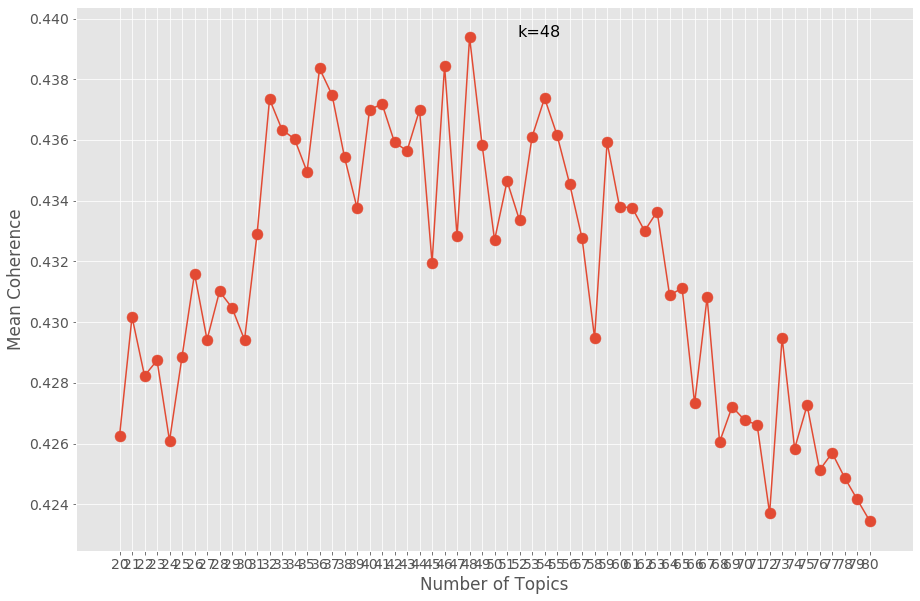

In [24]:
fig = plt.figure(figsize=(15,10))
# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")
# add the points
plt.scatter( k_values, coherences, s=120)
# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
plt.rc('xtick', labelsize=8)    # fontsize of the tick labels
plt.rc('ytick', labelsize=8) 
plt.rc('axes', titlesize=10)     # fontsize of the axes title
plt.rc('axes', labelsize=10) 
# show the plot
plt.show()

### Examine the Final Model

In [26]:
# the plot above suggests that the most appropriate value of the number of topics is k=28
k = best_k
# get the model that we generated earlier.
W = topic_models[k-kmin][1]
H = topic_models[k-kmin][2]

In [27]:
# display the topic descriptors for this model
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10 )
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: 产能, 万吨, 亿元, 煤炭, 发改委, 电价, 财新, 集团, 发电, 铁路
Topic 02: 医院, 病人, 患者, 医生, 发热, 医护人员, 确诊, 收治, 武汉市, 治疗
Topic 03: 习近平, 中共, 领导人, 毛泽东, 政治, 邓小平, 党内, 领导, 主席, 权力
Topic 04: 增速, 增长, 放缓, 经济学家, 同比, 下降, 下滑, 增幅, 百分点, 数据
Topic 05: 计算机, 机器, 人工智能, 算法, 机器人, 技术, 学习, 人类, 传感器, 智能
Topic 06: 利率, 美联储, 通胀, 央行, 货币政策, 降息, 衰退, 经济衰退, 经济学家, 宽松
Topic 07: 冠状病毒, 海鲜, 蝙蝠, 病毒, 武汉, 肺炎, 疾控中心, 病原体, 华南, 宿主
Topic 08: 复工, 疫情, 复产, 春节, 恢复, 中小企业, 新冠, 订单, 员工, 冲击
Topic 09: 关税, 协议, 特朗普, 贸易, 农产品, 谈判, 第一阶段, 加征, 贸易战, 达成
Topic 10: 朋友, 孩子, 父亲, 家里, 生活, 感觉, 父母, 母亲, 喜欢, 家人
Topic 11: 社会, 世纪, 历史, 政治, 人类, 世界, 文化, 资本主义, 理解, 自由
Topic 12: 香港, 抗议者, 抗议, 警方, 示威者, 活动, 示威, 香港政府, 法案, 警察
Topic 13: 香港, 社团, 福建, 立法会, 内地, 传媒, 反修, 示威者, 运动, 建制
Topic 14: 指数, 股市, 下跌, 标普, 跌幅, 国债, 股票, 投资者, 抛售, 股指
Topic 15: 中国外交部, 华尔街日报, 驱逐, 外国, 中国政府, 外交部, 新闻, 发言人, 北京, 媒体
Topic 16: 用户, 平台, 流量, 腾讯, 电商, 头部, 上线, 互联网, 品牌, 广告
Topic 17: 品牌, 沃尔玛, 零售商, 销售额, 亚马逊, 销售, 门店, 消费者, 顾客, 商品
Topic 18: 贷款, 银行, 违约, 债券, 融资, 债务, 发行, 信用, 信贷, 资金
Topic 19: 球迷, 火箭队, 比赛, 球员, 莫雷, 球队, 篮球, 推文, 体育, 休斯顿
Topic 2

## NMF Topic Models

In [28]:
# Topic modelling aims to automatically discover the hidden thematic strcuture in a large corpus of text documents. 
# One approach for topic modelling is to apply matrix factorization methods, such as Non-negative Matrix Factorization (NMF)
# we will apply NMF using the scikit-learn library 

## Applying NMF

In [29]:
# create the model
# Most commonly, NMF involves using random initilization to populate the values in the factors W and H.
# Depending on the random seed that you use, you may get different results on the same dataset.
# Another choice for NMF revolves around initialization. Using SVD-based initialization provides more reliable results.
model = decomposition.NMF( init="nndsvd", n_components=k ) 
# apply the model and extract the two factor matrices
W = model.fit_transform( A ) 
# nmf_tfidf
H = model.components_

### Examining the Output

In [30]:
# NMF produces two factor matrices as its output: W and H.
# The W factor contains the document membership weights relative to each of the k topics. 
# Each row correpsonds to a single documents, and each column corresponds to a topic.

In [31]:
W.shape

(1516, 48)

In [32]:
# For instance, for the first output, we see that it is strongly associated with one topic.
# However, each document can be potentially associated with multiple topics to different degrees.

# round to 2 decimal places for display purposes
W[0,:].round(2)

array([0.  , 0.  , 0.05, 0.  , 0.03, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.02, 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.  , 0.  ,
       0.01, 0.03, 0.  , 0.03, 0.  , 0.  , 0.  , 0.  , 0.01, 0.01, 0.02,
       0.  , 0.02, 0.04, 0.01])

In [33]:
# The H factor contains the term weights relative to each of the k topics. 
# In this case, each row corresponds to a topic, and each column corresponds to a unique term in the corpus vocabulary
H.shape

(48, 9598)

In [34]:
# For instance, for the term "中国", we see that it is strongly associated with a single topic. 
# Again, in some cases each term can be associated with multiple topics

term_index = terms.index('复工')
# round to 2 decimal places for display purposes
H[:,term_index].round(2)

array([0.  , 0.  , 0.  , 0.1 , 0.  , 0.  , 0.  , 0.48, 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.07, 0.  ])

### Topic Descriptors

In [35]:
# The top ranked terms for the H facotr for each topic can give us an insight into the content of that topic.
# This is oftened called the topic descriptor. 
# using function get_descriptor, we can extract the descriptor for a specified topic using the top ranked terms (e.g. top 10)
descriptors = []
for topic_index in range(k):
    descriptors.append( get_descriptor( terms, H, topic_index, 15 ) )
    str_descriptor = ", ".join( descriptors[topic_index] )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: 银行, 贷款, 金融机构, 金融, 监管, 存款, 财新, 银行业, 信用, 央行, 还款, 商业银行, 风险, 客户, 监管部门
Topic 02: 医院, 病人, 医生, 患者, 医护人员, 发热, 床位, 门诊, 收治, 救治, 武汉市, 治疗, 确诊, 重症, 肺炎
Topic 03: 世纪, 历史, 人类, 资本主义, 作者, 年代, 世界, 社会, 时代, 读者, 出版, 战争, 自由主义, 自由, 精英
Topic 04: 供应链, 工厂, 生产, 制造, 供应商, 关税, 工人, 制造业, 跨国公司, 零部件, 贸易战, 贸易, 越南, 库存, 制造商
Topic 05: 计算机, 机器, 人工智能, 算法, 机器人, 技术, 学习, 人类, 传感器, 软件, 智能, 识别, 预测, 数据, 生成
Topic 06: 人口, 年龄, 劳动力, 富裕, 收入, 养老, 养老金, 老年人, 健康, 老龄化, 退休, 家庭, 财富, 寿命, 生活
Topic 07: 海鲜, 冠状病毒, 肺炎, 蝙蝠, 疾控中心, 病毒, 华南, 武汉, 病原体, 样本, 宿主, 检测, 传染病, 动物, 序列
Topic 08: 口罩, 复工, 物资, 疫情, 武汉, 湖北, 防疫, 医用, 防控, 防护服, 春节, 订单, 肺炎, 医疗, 复产
Topic 09: 关税, 协议, 贸易, 特朗普, 农产品, 加征, 第一阶段, 谈判, 贸易战, 达成, 贸易谈判, 莱特, 商品, 中方, 希泽
Topic 10: 朋友, 父亲, 家里, 孩子, 感觉, 生活, 喜欢, 儿子, 家人, 母亲, 父母, 离开, 出门, 晚上, 回来
Topic 11: 电影, 导演, 作品, 观众, 影片, 好莱坞, 奖项, 故事, 演员, 编剧, 剧本, 奥斯卡, 创作, 最佳, 上映
Topic 12: 香港, 抗议者, 抗议, 示威者, 活动, 示威, 香港政府, 警方, 法案, 郑月, 警察, 暴力, 引渡, 内地, 骚乱
Topic 13: 香港, 社团, 福建, 立法会, 传媒, 内地, 示威者, 反修, 建制, 市民, 运动, 特区政府, 特首, 郑月, 基本法
Topic 14: 指数, 股市, 下跌, 跌幅, 标普, 股票, 国债, 投资者, 抛售, 

In [47]:
# The rankings above do not show the strength of association for the different terms. 
# We can represent the distribution of the weights for the top terms in a topic using a matplotlib horizontal bar chart.
plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

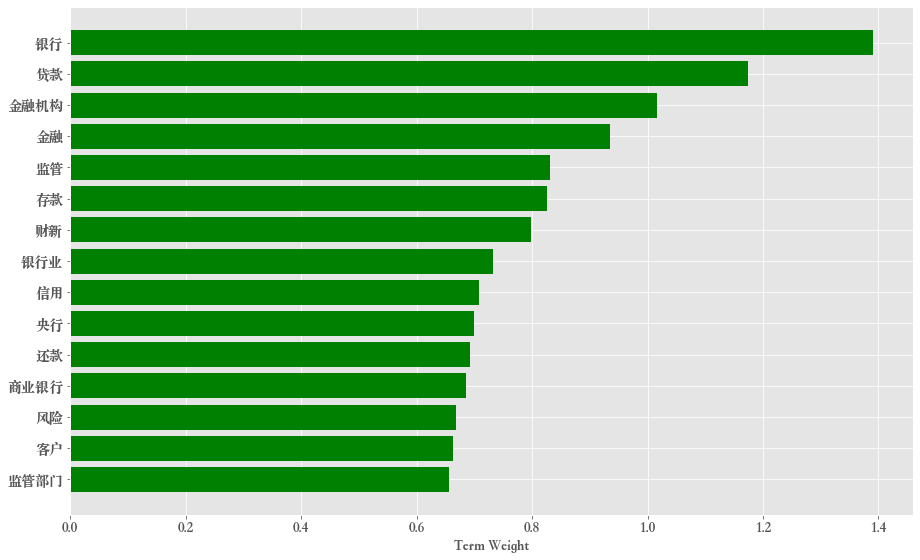

<Figure size 432x288 with 0 Axes>

In [50]:
# fix font issues
from matplotlib import rcParams, font_manager
cfont = font_manager.FontProperties(fname='/Library/Fonts/Songti.ttc')
rcParams["font.family"] = cfont.get_name()
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14) 
plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=14) 
# so for instance, for the 7th topic, we can generate a plot with the top 15 terms using
plot_top_term_weights( terms, H, 0, 15 )

In [38]:
# For instance, for the first topic listed above, the 10 documents are
topic_snippets = get_top_snippets( snippets, W, 0, 10 )
for i, snippet in enumerate(topic_snippets):
    print("%02d. %s" % ( (i+1), snippet ) )

01. 煤炭大省山西欲转型「氢谷」，但看似成本低廉的煤制氢路径却充满争议和障碍山西省欲打造中国「氢谷」。这个听起来十分时髦的词汇，并不仅仅是山西产业转型选择的方向。广东佛山、山东济南、吉林白城等全国 20 多个地区都在陆续喊出类似的口号，只不过山西省打造「氢谷」的制氢路径不同——煤制氢。作为产煤大省，山西省
02. 大数据风控模式之外，还有依赖客户经理队伍线下搜集风控信息、线上不断完善模型来有效服务小微企业的另一种模式借力金融科技的联合贷款或助贷，是普惠信贷的惟一解决方案吗？答案是不。过去五年间，尽管中国数字金融服务在规模和广度上都取得了令人瞩目的成就，但数字技术的发展并未能完全解决金融服务对中低收入人群的覆盖
03. 欧洲是华为的「粮仓」和「第二本土」。面对美国政府对华为的制裁，欧洲人会作出怎样的选择？瑞士最大城市苏黎世的郊区，电信运营商 Sunrise 总部，前来参观的人络绎不绝。10 月 14 日，在全球移动宽带论坛开幕的前一天，Sunrise 在这里展示了与华为合作的欧洲首家 5G 联合创新中心，用于孵化云
04. 如果你之前认为贸易战对跨境贸易而言很糟糕……​​​集装箱船领航员、海关官员、物流专家、卡车司机和仓库夜间值班人员：所有这些人都擅长对付和国际贸易相关的麻烦，不论是罢工还是贸易战。但是，随着有关今年全球 GDP 大跌的预测浮现，即便是他们最有创意的想法也无法维持 25 万亿美元的商品和服务在世界各地继
05. 一位陨落的企业明星反省自己在德国商业中的失败经历传媒集团贝塔斯曼的前老板、曾经在柏林乃至好莱坞都广受赞誉的托马斯·米德尔霍夫 (Thomas Middelhoff) 于 8 月 20 日发布了新书《有罪》(Guilty)。这并不是法律意义上的认罪——他仍然认为自己因逃税和违反信托获刑三年的判罚过重了
06. 更为微妙的控制依然存在中国西北部喀什的一所穆斯林再教育中心最近刚刚清空，数百个废弃的金属床架杂乱地堆放在草地上。床架上的红色贴纸上写着：识错，认错，悔过。中国官员说，这类中心 (北京方面描述为职业技术学校) 的学员已经全部结业。人权组织及西方政府则称，近年来，遍布新疆的数十所此类再教育中心曾扣押约 
07. 3000 亿元央行专项再贷款，如何投向新冠肺炎疫情防控最急需资金的企业，如何防范利益博弈和道德风险，阳光化运作最关键2 月 4 日，

In [39]:
# Similar, for the second topic:
topic_snippets = get_top_snippets( snippets, W, 1, 10 )
for i, snippet in enumerate(topic_snippets):
    print("%02d. %s" % ( (i+1), snippet ) )

01. 没有人知道疫情会有多严重，而全球化受到的冲击将久久不散对于世界各地的商业人士来说，起源于中国的新型冠状病毒正在导致严重的认知失调。他们眼睛看到的状况很不妙：死亡人数不断上升，历史上最大规模的隔离行动，国际边境关闭，供应链断裂，业务受到冲击。然而经济学家却说，疫情只会导致中国 2020 年经济增幅降低
02. 香港的示威者Protesters photographed in Hong Kong.Photo: Heather Sten for Bloomberg Businessweek香港的示威活动已经持续超过六个月，根据民阵统计，最高峰时期曾有逾 200 万人参与示威游行。今年早些时候，香港政府提出了一
03. 走过的人说树枝低了，走过的人说树枝在长瘟疫如同放大镜，将中国统治系统的黑暗、腐败、无情、无能，戏剧化地集中展现。去年底至今，越来越多曾经相信「国家总是有办法的」、「中央会负责的」的民众恍然大悟：当权者追求「国泰」，但并不一定包括「民安」，专制国家的「贤能政治」，似乎不再能承载幻想。有分析者据此认为，
04. 勾勒湖北防疫战全景，寻找终止疫情的密码发端于武汉的新冠肺炎，迄今已盘桓两月有余。病毒从何而来尚不完全明了，疫情止于何处，却已清晰。这是一场人类与病毒的较量，惜乎武汉疫情警报拉响姗姗来迟，而实力一度被低估的对手已沿着发达的交通线和城市圈层，迅速向外逸散。一座座城池渐次陷落。何时收复？关于疫情拐点将至的
05. 这部失意于奖项的电影并非要讲婚姻和感情的吊诡，粗暴的感同身受便错过了作品的精彩之处集编导一身的电影人 Noah Baumbach 擅长写日常的情感与关系，他的作品一向讲生活之中最真切的事，最平易近人，没想到却一直不讨好。我是说，他在欧美总是得到铺天盖地的好评，却从来都失意于奖项。所以他去年和 Net
06. 为了让该政权能便利行事，他们就迫使某人重新成为中国公民中国一家法院以为境外非法提供情报罪判处一名出生在中国、拥有瑞典公民身份的书商 10 年监禁，并表示他的中国国籍已恢复。这凸显出北京方面在对外国公民行使管辖权方面越来越强硬。桂敏海周一被判刑，他出售的书籍包括在中国大陆被禁的政治八卦类书籍。四年多前
07. 领航集团 (Vanguard) 首席执行官兼董事长Mortimer “Tim” Buckley, CEO and chairman 

### Exporting the Results & Visualization

In [40]:
# we want to keep this topic model for later use by saving it using joblib
joblib.dump((W,H,terms,snippets), "articles-model-nmf-k%02d.pkl" % k )

['articles-model-nmf-k48.pkl']

### Visualizing using pyLDAvis

In [41]:
# Visualize the various topics, using pyLDAvis
# pyLDAvis does not handle documents that have no words in any of the topics (for example because they are empty documents, or contain only stopwords).
# to avoid problems, we need to remove any such documents prior to visualizing

In [51]:
pyLDAvis.sklearn.prepare(model, A, vectorizer, mds='mmds', sort_topics=False)
data = pyLDAvis.sklearn.prepare(model, A, vectorizer, mds='mmds', sort_topics=False)

/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide 

In [52]:
# save as a html
# pyLDAvis.save_html(data,'tm_vis2020.html')
pyLDAvis.save_html(data,'tm_vis.html')

## Visualizing Topic Significance over Time

In [53]:
plt.figure(dpi=1200)

<Figure size 7200x4800 with 0 Axes>

<Figure size 7200x4800 with 0 Axes>

In [54]:
# print(W)
W.shape

(1516, 48)

In [55]:
# there's no published date on the same page with the article. So we will use a simple, naive method:
# 1516 articles, 275 days=15days as a time period, altogether about 18 time periods
# nested list: rows are articles aggregated together for each of the 18 time periods;
# columns are still 30 topics 
# the method is changed
nest_list = []
i = 0 
# while i <= 1344:
#     res = np.sum(W[i:i+84], 0) 
#     nest_list.append(res)
#     i += 84
res = np.sum(W[:82],0)
nest_list.append(res)
res = np.sum(W[86:172],0)
nest_list.append(res)
res = np.sum(W[172:278],0)
nest_list.append(res)
res = np.sum(W[278:371],0)
nest_list.append(res)
res = np.sum(W[371:470],0)
nest_list.append(res)
res = np.sum(W[470:554],0)
nest_list.append(res)
res = np.sum(W[554:712],0)
nest_list.append(res)
res = np.sum(W[712:797],0)
nest_list.append(res)
res = np.sum(W[797:934],0)
nest_list.append(res)
res = np.sum(W[934:1023],0)
nest_list.append(res)
res = np.sum(W[1023:1106],0)
nest_list.append(res)
res = np.sum(W[1106:1206],0)
nest_list.append(res)
res = np.sum(W[1206:1289],0)
nest_list.append(res)
res = np.sum(W[1289:1329],0)
nest_list.append(res)
res = np.sum(W[1329:1365],0)
nest_list.append(res)
res = np.sum(W[1365:1404],0)
nest_list.append(res)
res = np.sum(W[1404:1457],0)
nest_list.append(res)
res = np.sum(W[1457:],0)
nest_list.append(res)
print(len(nest_list))
# print(nest_list)

18


In [56]:
# using this function we can know approximate gross number of topic significance for a time period
def array_summer(arr):
    total = 0
    for item in arr:
        # shorthand of total = total + item
        total += item
    return total

summal = 0
for array in nest_list:
    summal = max(summal, array_summer(array))
print(summal)

54.769572891435025


In [57]:
# we will first normalize the arrays: each = topic weights for one time period by adding them up, dividing them by sum
# so then their sum will be 1, which means the values on different scales are adjusted to the same scale
normed = []
for array in nest_list:
    norm_1 = [float(i)/sum(array) for i in array]
    normed.append(norm_1)
# norm_2 = [float(i)/max(array) for i in raw]
print(len(normed))
# print(normed)

18


In [58]:
# Unnormalized data
# making a dataframe for nested list
df = pd.DataFrame(nest_list)
df = df.reindex(index=df.index[::-1])
df.head()

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
17,0.207362,0.019854,0.375238,0.889121,0.324183,0.317015,0.054593,0.015855,0.545003,0.457809,...,3.439719,0.513599,3.157728,0.120944,0.279128,0.451149,0.937339,0.034659,0.447732,0.621199
16,0.165871,0.160480,0.337352,0.800506,0.619628,0.420708,0.054612,0.046484,0.532774,0.320631,...,1.126232,0.751330,0.271389,0.303210,0.368153,0.633725,0.634326,0.105167,1.113622,0.521629
15,0.066564,0.058810,0.188556,0.395126,0.329094,0.547649,0.006224,0.038008,0.517029,0.170877,...,0.309677,0.816987,0.899401,0.094551,0.220117,0.371194,0.065364,0.091284,0.880843,0.238811
14,0.176296,0.001688,0.290440,0.158690,0.260543,0.051748,0.071328,0.044848,0.113460,0.169349,...,0.818757,0.559461,0.701469,0.071667,0.386663,0.402702,0.165093,0.058360,0.449989,0.288841
13,0.066162,0.043896,0.294020,0.125978,0.067100,0.239773,0.007675,0.071640,0.486146,0.359328,...,0.436797,0.435473,0.235008,0.466335,0.238796,0.344982,0.569035,0.084189,0.157843,0.676307


In [59]:
# giving topic names as column names
# df.columns = ["topic 1","topic 2", "topic 3", "topic 4", "topic 5", "topic 6", "topic 7", "topic 8", "topic 9", "topic 10", \
#               "topic 11","topic 12","topic 13","topic 14","topic 15","topic 16","topic 17","topic 18","topic 19","topic 20",\
#               "topic 21","topic 22","topic 23","topic 24","topic 25","topic 26","topic 27","topic 28","topic 29","topic 30"]
df.columns = [
    "1 Banking",\
    "2 China COVID-19 HealthCare",\
    "3 Poli&Soci Thought1",\
    "4 Supply Chain",\
    "5 Tech1(AI)",\
    "6 Soeicty",\
    "7 COVID-19 Origin",\
    "8 Back to Work", \
    "9 US-China Trade War", \
    "10 Life",\
    "11 Entertainment Industry",\
    "12 HongKong Protest1",\
    "13 HongKong Election",\
    "14 US Stock Market",\
    "15 Domestic Opposition",\
    "16 Internet",\
    "17 Commerce/Sales",\
    "18 Loan/Debt",\
    "19 Houston Rockets",\
    "20 Middle East",\
    "21 Entertainment Industry2",\
    "22 Stock Investment",\
    "23 CCP",\
    "24 Automobile",\
    "25 Climate Change",\
    "26 Food",\
    "27 Agriculture",\
    "28 Chinese ministry of Foreign Affairs",\
    "29 Taiwan Election",\
    "30 Poli&Soci Thought2",\
    "31 Building Land",\
    "32 Currency",\
    "33 Data Privacy",\
    "34 EU",\
    "35 Oil",\
    "36 Xinjiang Uyghurs",\
    "37 Education",\
    "38 Public Policy",\
    "39 Aerospace",\
    "40 Tech2(Huawei)",\
    "41 Aviation",\
    "42 Protest2(Police)",\
    "43 Medical Research",\
    "44 US Politics",\
    "45 Stock Ownership",\
    "46 COVID-19 Cases",\
    "47 Economic Growth",\
    "48 Judiciary"]
len(df.columns)
# df

48

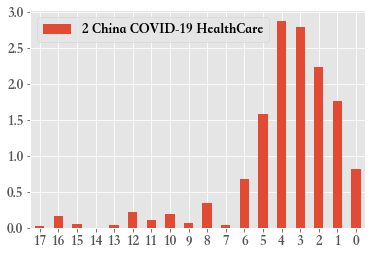

In [62]:
# plot a bar plot for a single topic's weight over time
ax = df.plot.bar(y="2 China COVID-19 HealthCare", rot=0)

In [63]:
# since plot will be very strange when using unnormalized data to plot, I'm not going to do this
# axssh = df.plot.bar(stacked=True, figsize=(10,5), color=color_sequence, alpha=0.7)
# axssh.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [64]:
# axssesh = df.plot.area(stacked=True, figsize=(11,5), color=color_sequence, alpha=0.7)
# axssesh.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [65]:
# Here I am creating a dataframe for the normalized data (18 rows/time periods * 30 columns/topic weights)
df_normed = pd.DataFrame(normed)
# before the data is ordered from latest/newest(line 1) to oldest(line 17)
# now changing time periods order to make the 4/05-4/20/2020 period be the last one and 7/05-7/20/2019 the first
df_normed = df_normed.reindex(index=df_normed.index[::-1])
df_normed.head()

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
17,0.008855,0.000848,0.016024,0.037968,0.013843,0.013537,0.002331,0.000677,0.023273,0.019550,...,0.146884,0.021932,0.134842,0.005165,0.011919,0.019265,0.040027,0.001480,0.019119,0.026527
16,0.008580,0.008301,0.017451,0.041409,0.032052,0.021763,0.002825,0.002405,0.027559,0.016586,...,0.058258,0.038865,0.014038,0.015685,0.019044,0.032782,0.032813,0.005440,0.057606,0.026983
15,0.004411,0.003897,0.012494,0.026181,0.021806,0.036287,0.000412,0.002518,0.034259,0.011322,...,0.020519,0.054134,0.059595,0.006265,0.014585,0.024595,0.004331,0.006048,0.058365,0.015824
14,0.013716,0.000131,0.022597,0.012346,0.020271,0.004026,0.005549,0.003489,0.008827,0.013176,...,0.063701,0.043527,0.054575,0.005576,0.030083,0.031331,0.012844,0.004540,0.035010,0.022472
13,0.004592,0.003047,0.020407,0.008744,0.004657,0.016642,0.000533,0.004972,0.033742,0.024940,...,0.030317,0.030225,0.016311,0.032367,0.016574,0.023944,0.039495,0.005843,0.010955,0.046940


In [66]:
# giving topic names as column names
# df_normed.columns = ["topic 1","topic 2", "topic 3", "topic 4", "topic 5", "topic 6", "topic 7", "topic 8", "topic 9", "topic 10", \
#               "topic 11","topic 12","topic 13","topic 14","topic 15","topic 16","topic 17","topic 18","topic 19","topic 20",\
#               "topic 21","topic 22","topic 23","topic 24","topic 25","topic 26","topic 27","topic 28","topic 29"]
# df_normed.columns = ["Public Policy","COVID-19 Health Care", "Political Thought", "Supply Chain", "Technology",\
#               "Economy/Currency","COVID-19 Research","Back to Work", "US-China Trade War", "Life",\
#               "Entertainment Industry","Hong Kong Protest","Domestic Opposition","US Stock Market","Xinjiang Uyghurs",\
#               "Internet","Big Business","Loan/Debt","Houston Rockets","International Relations",\
#               "Judiciary","Society", "Taiwan Presidential Election","Automobile", "Aerospace/Aviation",\
#               "Agriculture","Equity","COVID-19 Cases","Foreign Politics"]
df_normed.columns = df.columns 
df_normed = df_normed.rename(index={17:"7/20-8/05", 16: "8/05-8/20", 15: "8/20-9/05", 14:"9/05-9/20",\
                        13: "9/20-10/05", 12:"10/05-10/20",11:"10/20-11/05",10: "11/05-11/20",\
                        9:"11/20-12/05", 8:"12/05-12/20",7:"12/20-1/05",6:"1/05-1/20",5:"1/20-2/05",\
                        4:"2/05-2/20",3:"2/20-3/05",2:"3/05-3/20",1:"3/20-4/05",0:"4/05-4/20"})
df_normed.head()

,1 Banking,2 China COVID-19 HealthCare,3 Poli&Soci Thought1,4 Supply Chain,5 Tech1(AI),6 Soeicty,7 COVID-19 Origin,8 Back to Work,9 US-China Trade War,10 Life,...,39 Aerospace,40 Tech2(Huawei),41 Aviation,42 Protest2(Police),43 Medical Research,44 US Politics,45 Stock Ownership,46 COVID-19 Cases,47 Economic Growth,48 Judiciary
7/20-8/05,0.008855,0.000848,0.016024,0.037968,0.013843,0.013537,0.002331,0.000677,0.023273,0.019550,...,0.146884,0.021932,0.134842,0.005165,0.011919,0.019265,0.040027,0.001480,0.019119,0.026527
8/05-8/20,0.008580,0.008301,0.017451,0.041409,0.032052,0.021763,0.002825,0.002405,0.027559,0.016586,...,0.058258,0.038865,0.014038,0.015685,0.019044,0.032782,0.032813,0.005440,0.057606,0.026983
8/20-9/05,0.004411,0.003897,0.012494,0.026181,0.021806,0.036287,0.000412,0.002518,0.034259,0.011322,...,0.020519,0.054134,0.059595,0.006265,0.014585,0.024595,0.004331,0.006048,0.058365,0.015824
9/05-9/20,0.013716,0.000131,0.022597,0.012346,0.020271,0.004026,0.005549,0.003489,0.008827,0.013176,...,0.063701,0.043527,0.054575,0.005576,0.030083,0.031331,0.012844,0.004540,0.035010,0.022472
9/20-10/05,0.004592,0.003047,0.020407,0.008744,0.004657,0.016642,0.000533,0.004972,0.033742,0.024940,...,0.030317,0.030225,0.016311,0.032367,0.016574,0.023944,0.039495,0.005843,0.010955,0.046940


In [67]:
# df_normed = df_normed.rename(index={17:"7月下-8月上", 16: "8月上-8月下", 15: "8月下-9月上", 14:"9月上-9月下",\
#                                     13: "9月下-10月上", 12:"10月上-10月下",11:"10月下-11月上",10: "11月上-11月下",\
#                                     9:"11月下-12月上", 8:"12月上-12月下",7:"12月下",6:"1月上",5:"1月下",\
#                                     4:"2月上",3:"2月下",2:"3月上",1:"3月下",0:"4月上"})

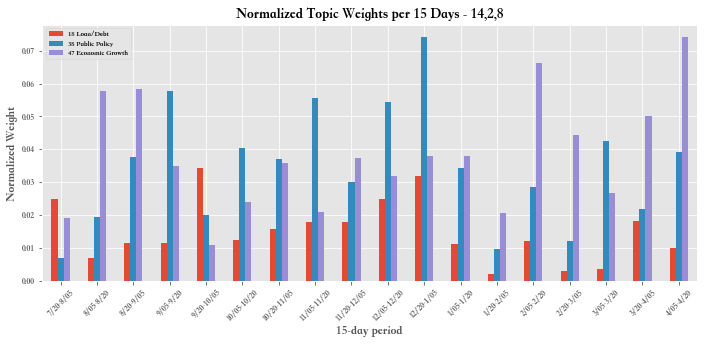

In [87]:
# forthcoming a series of plots of which the use is to see relationships between topic weights so as to see topic relevance
axs = df_normed.plot.bar(y=["18 Loan/Debt","4 Supply Chain","47 Economic Growth"] ,rot=45, figsize=(10,5))
plt.rc('xtick', labelsize=8)    # fontsize of the tick labels
plt.rc('ytick', labelsize=8) 
plt.rc('axes', titlesize=10)     # fontsize of the axes title
plt.rc('axes', labelsize=10) 
axs.set_title('Normalized Topic Weights per 15 Days - 14,2,8',fontsize=14)
axs.set_xlabel('15-day period',fontsize=12)
axs.set_ylabel('Normalized Weight',fontsize=12)
plt.tight_layout()
plt.savefig('1428.svg',dpi=1200)
# axs = df_normed.plot(figsize=(10,5))

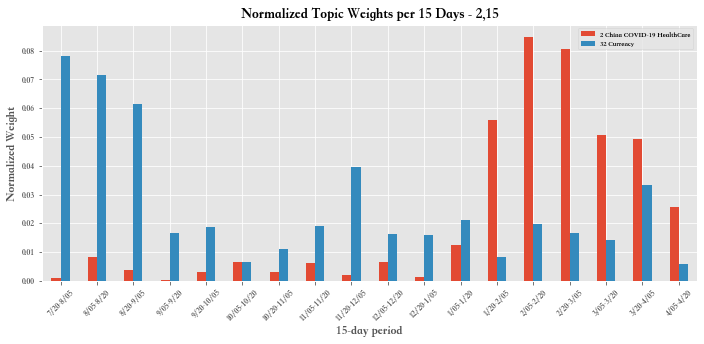

In [88]:
axsq = df_normed.plot.bar(y=["2 China COVID-19 HealthCare","32 Currency"] ,rot=45, figsize=(10,5))
axsq.set_title('Normalized Topic Weights per 15 Days - 2,15',fontsize=14)
axsq.set_xlabel('15-day period',fontsize=12)
axsq.set_ylabel('Normalized Weight',fontsize=12)
plt.tight_layout()
plt.savefig('2&15.svg',dpi=1200)

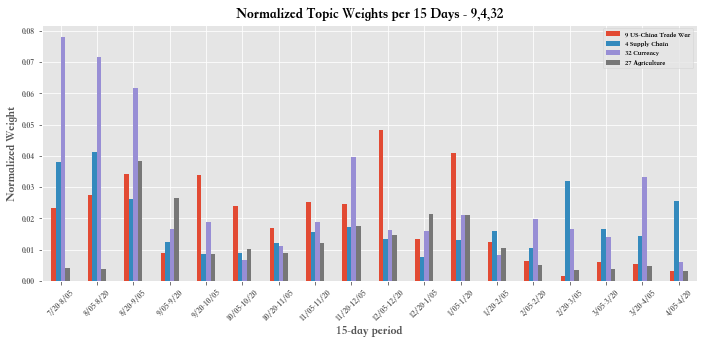

In [92]:
axsq = df_normed.plot.bar(y=["9 US-China Trade War", "4 Supply Chain","32 Currency","27 Agriculture"] ,rot=45, figsize=(10,5))
plt.rc('xtick', labelsize=8)    # fontsize of the tick labels
plt.rc('ytick', labelsize=8) 
plt.rc('axes', titlesize=10)     # fontsize of the axes title
plt.rc('axes', labelsize=10) 
axsq.set_title('Normalized Topic Weights per 15 Days - 9,4,32',fontsize=14)
axsq.set_xlabel('15-day period',fontsize=12)
axsq.set_ylabel('Normalized Weight',fontsize=12)
plt.tight_layout()
plt.savefig('271418.svg',dpi=1200)

In [ ]:
axsq = df_normed.plot.bar(y=["15 COVID-19 Cases","8 Back to Work","13 Domestic Opposition"] ,rot=45, figsize=(10,5))

In [ ]:
axsw = df_normed.plot.bar(y=["9 US-China Trade War","26 Agriculture"] ,rot=45, figsize=(10,5))

In [ ]:
axsw = df_normed.plot.bar(y=["26 Agriculture","27 Economy/Currency"] ,rot=45, figsize=(10,5))

In [ ]:
# axse = df_normed.plot.bar(y=['US-China Trade War',"Xinjiang Uyghurs","Taiwan Presidential Election"] ,rot=45, figsize=(10,5))
axse = df_normed.plot.bar(y="25 Life",rot=45, figsize=(10,5))

In [70]:
color_sequence = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
                  '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
                  '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
                  '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5',
                 '#800080', '#FF00FF', '#000080', '#0000FF', '#008080',
                  '#00FFFF', '#008000', '#00FF00', '#808000', '#FFFF00',
                  '#800000', '#FF0000', '#000000', '#808080', '#C0C0C0',
                  '#FFFFFF', '#B22222', '#F08080', '#FF69B4', '#FF7F50',
                  '#FFFF00',
                  '#BDB76B', '#BC8F8F', '#8B4513', '#00008B', '#FFE4E1',
                  '#008080',
                  '#00CED1', '#00CED1']

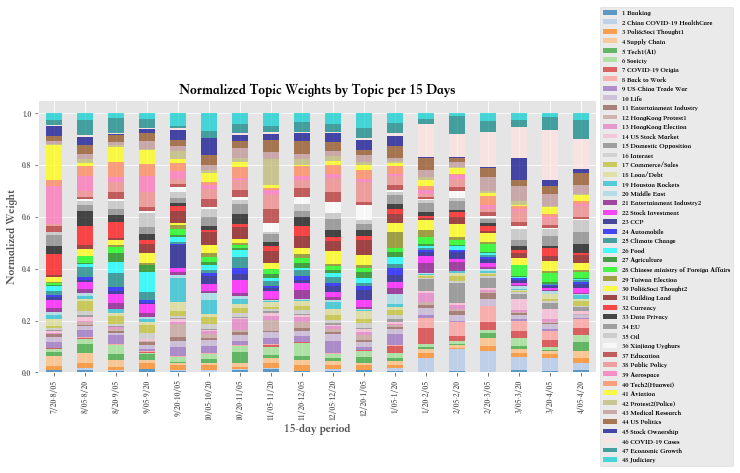

In [78]:
# forthcoming the bar plots that help us to see the trend of topic significance more clearly
rcParams['legend.fontsize'] = 7
axss = df_normed.plot.bar(stacked=True, figsize=(10,5), color=color_sequence, alpha=0.7)
axss.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.rc('xtick', labelsize=8)    # fontsize of the tick labels
plt.rc('ytick', labelsize=8) 
plt.rc('axes', titlesize=10)     # fontsize of the axes title
plt.rc('axes', labelsize=10) 
axss.set_title('Normalized Topic Weights by Topic per 15 Days',fontsize=14)
axss.set_xlabel('15-day period',fontsize=12)
axss.set_ylabel('Normalized Weight',fontsize=12)
# plt.tight_layout()
plt.savefig('bar_plot.svg',dpi=1200)

In [ ]:
# # some code that could be used for plotting, only revise and use them if needed
# rcParams['font.family'] = 'Verdana'
# cfont = font_manager.FontProperties(fname='/Library/Fonts/Songti.ttc')
# rcParams["font.family"] = cfont.get_name()
# # rcParams['font.size'] = 16
# rcParams['legend.fontsize'] = 13
# # rcParams['figure.figsize'] = 16, 10
# # rcParams['legend.frameon'] = True
# axsser = df_normed.plot.bar(stacked=True, figsize=(10,5), color=color_sequence, alpha=0.7)
# axsser.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
# horizontal bar plot
axsse = df_normed.plot.barh(stacked=True, figsize=(10,5), color=color_sequence, alpha=0.7)
axsse.legend(loc='center left', bbox_to_anchor=(1, 0.5))
rcParams['legend.fontsize'] = 8
axsse.set_title('Normalized Topic Weights by Topic per 15 Days')
axsse.set_xlabel('Normalized Weight')
axsse.set_ylabel('15-day period')
plt.tight_layout()
plt.savefig('hbar_plot.svg',dpi=1200)

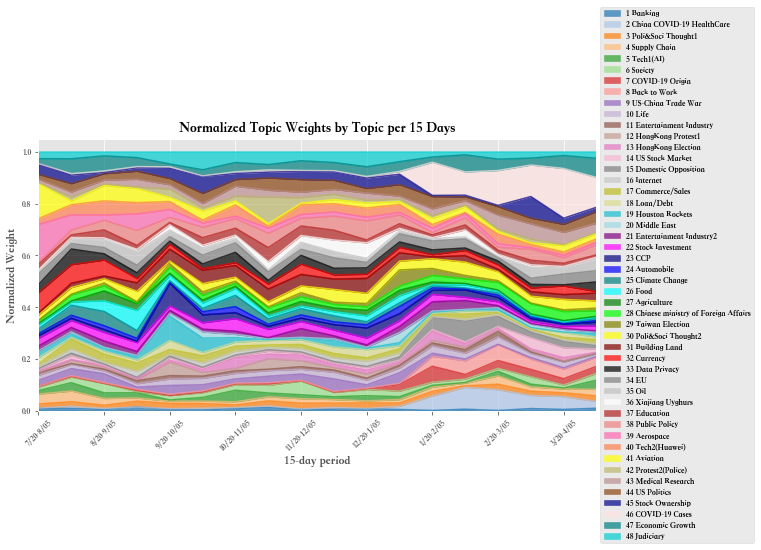

In [77]:
# area plot, another kind of plot that helps us to see the trend more clearly
axsses = df_normed.plot.area(stacked=True, figsize=(10,5), color=color_sequence, rot=45,alpha=0.7)
axsses.legend(loc='center left', bbox_to_anchor=(1, 0.5),fancybox=True
              #loc='upper center', bbox_to_anchor=(0.5, 1),ncol=7,fancybox=True
             )
rcParams['legend.fontsize'] = 6
plt.rc('xtick', labelsize=8)    # fontsize of the tick labels
plt.rc('ytick', labelsize=8) 
plt.rc('axes', titlesize=10)     # fontsize of the axes title
plt.rc('axes', labelsize=10) 
axsses.set_title('Normalized Topic Weights by Topic per 15 Days',fontsize=14)
axsses.set_xlabel('15-day period',fontsize=12)
axsses.set_ylabel('Normalized Weight',fontsize=12)
# plt.tight_layout()
plt.savefig('area_plot.svg',dpi=1200)

In [ ]:
# df_normed.groupby('country').plot(x='year', y='unemployment')
# fig, ac = plt.subplots()
# df.groupby('country').plot(x='year', y='unemployment', ax=ax, legend=False)
# df_normed.groupby('COVID-19 Health Care','COVID-19 Research','COVID-19 Cases').plot(x='time',y='topic significance', ac=ac)